### Import Libraries


In [145]:
import pandas as pd
import pathlib
from joblib import load
import itertools

from matplotlib import pyplot as plt

import sys

sys.path.append("../utils")
from split_utils import get_features_data
from train_utils import get_dataset
from evaluate_utils import class_PR_curves

from train_utils import get_X_y_data
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve
import numpy as np
from sklearn.preprocessing import label_binarize


### Load models and datasets


In [146]:
# load features data from indexes and features dataframe
data_split_path = pathlib.Path("../1.split_data/indexes/data_split_indexes.tsv")
data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)
features_dataframe_path = pathlib.Path("../0.download_data/data/labeled_data.csv.gz")
features_dataframe = get_features_data(features_dataframe_path)

save_dir = pathlib.Path("evaluations/class_precision_recall_curves/")
save_dir.mkdir(parents=True, exist_ok=True)

In [147]:
def class_PR_curves_SCM(
    single_cell_data: pd.DataFrame, log_reg_model, feature_type: str
):
    """
    save precision recall curves for each class to the save directory
    also, return the precision/recall data for each class in tidy long format

    Parameters
    ----------
    single_cell_data : pd.DataFrame
        single cell dataframe with correct cell metadata and feature data
    log_reg_model : sklearn classifier
        clasifier to get precision recall curves for
    feature_type : str
        which feature type is being evaluated (CP, DP, CP_and_DP)

    Returns
    -------
    matplotlib.figure.Figure
        figure with compilation of all class PR curves

    pd.DataFrame
        dataframe with precision/recall data for each class in tidy long format
    """

    phenotypic_classes = log_reg_model.classes_
    X, y = get_X_y_data(single_cell_data, feature_type)

    # binarize labels for precision recall curve function
    y_binarized = label_binarize(y, classes=phenotypic_classes)
    # predict class probabilities for feature data
    y_score = log_reg_model.predict_proba(X)

    # data from PR curves will be stored in tidy data format (eventually pandas dataframe)
    PR_data = []
    # which thresholds the precision/recalls correspond to
    PR_threshold = np.arange(single_cell_data.shape[0])
    # last values in precision/recall curve don't correspond to cell dataset
    PR_threshold = np.append(PR_threshold, None)

    fig, axs = plt.subplots(3, 5)
    fig.set_size_inches(15, 9)
    ax_x = 0
    ax_y = 0
    for i in range(phenotypic_classes.shape[0]):
        precision, recall, _ = precision_recall_curve(y_binarized[:, i], y_score[:, i])
        PR_data.append(
            pd.DataFrame(
                {
                    "Phenotypic_Class": phenotypic_classes[i],
                    "PR_Threshold": PR_threshold,
                    "Precision": precision,
                    "Recall": recall,
                }
            )
        )

        axs[ax_x, ax_y].plot(recall, precision, lw=2, label=phenotypic_classes[i])
        axs[ax_x, ax_y].set_title(phenotypic_classes[i])
        axs[ax_x, ax_y].set(xlabel="Recall", ylabel="Precision")

        # increase row coordinate counter (this marks which subplot to plot on in vertical direction)
        ax_x += 1
        # if row coordinate counter is at maximum (3 rows of subplots)
        if ax_x == 3:
            # set row coordinate counter to 0
            ax_x = 0
            # increase column coordinate counter (this marks which subplot to plot on in horizontal direction)
            ax_y += 1

    # only label outer plots
    for ax in axs.flat:
        ax.label_outer()

    PR_data = pd.concat(PR_data, axis=0).reset_index(drop=True)
    return fig, PR_data

### Evaluate each singleclass model on each dataset


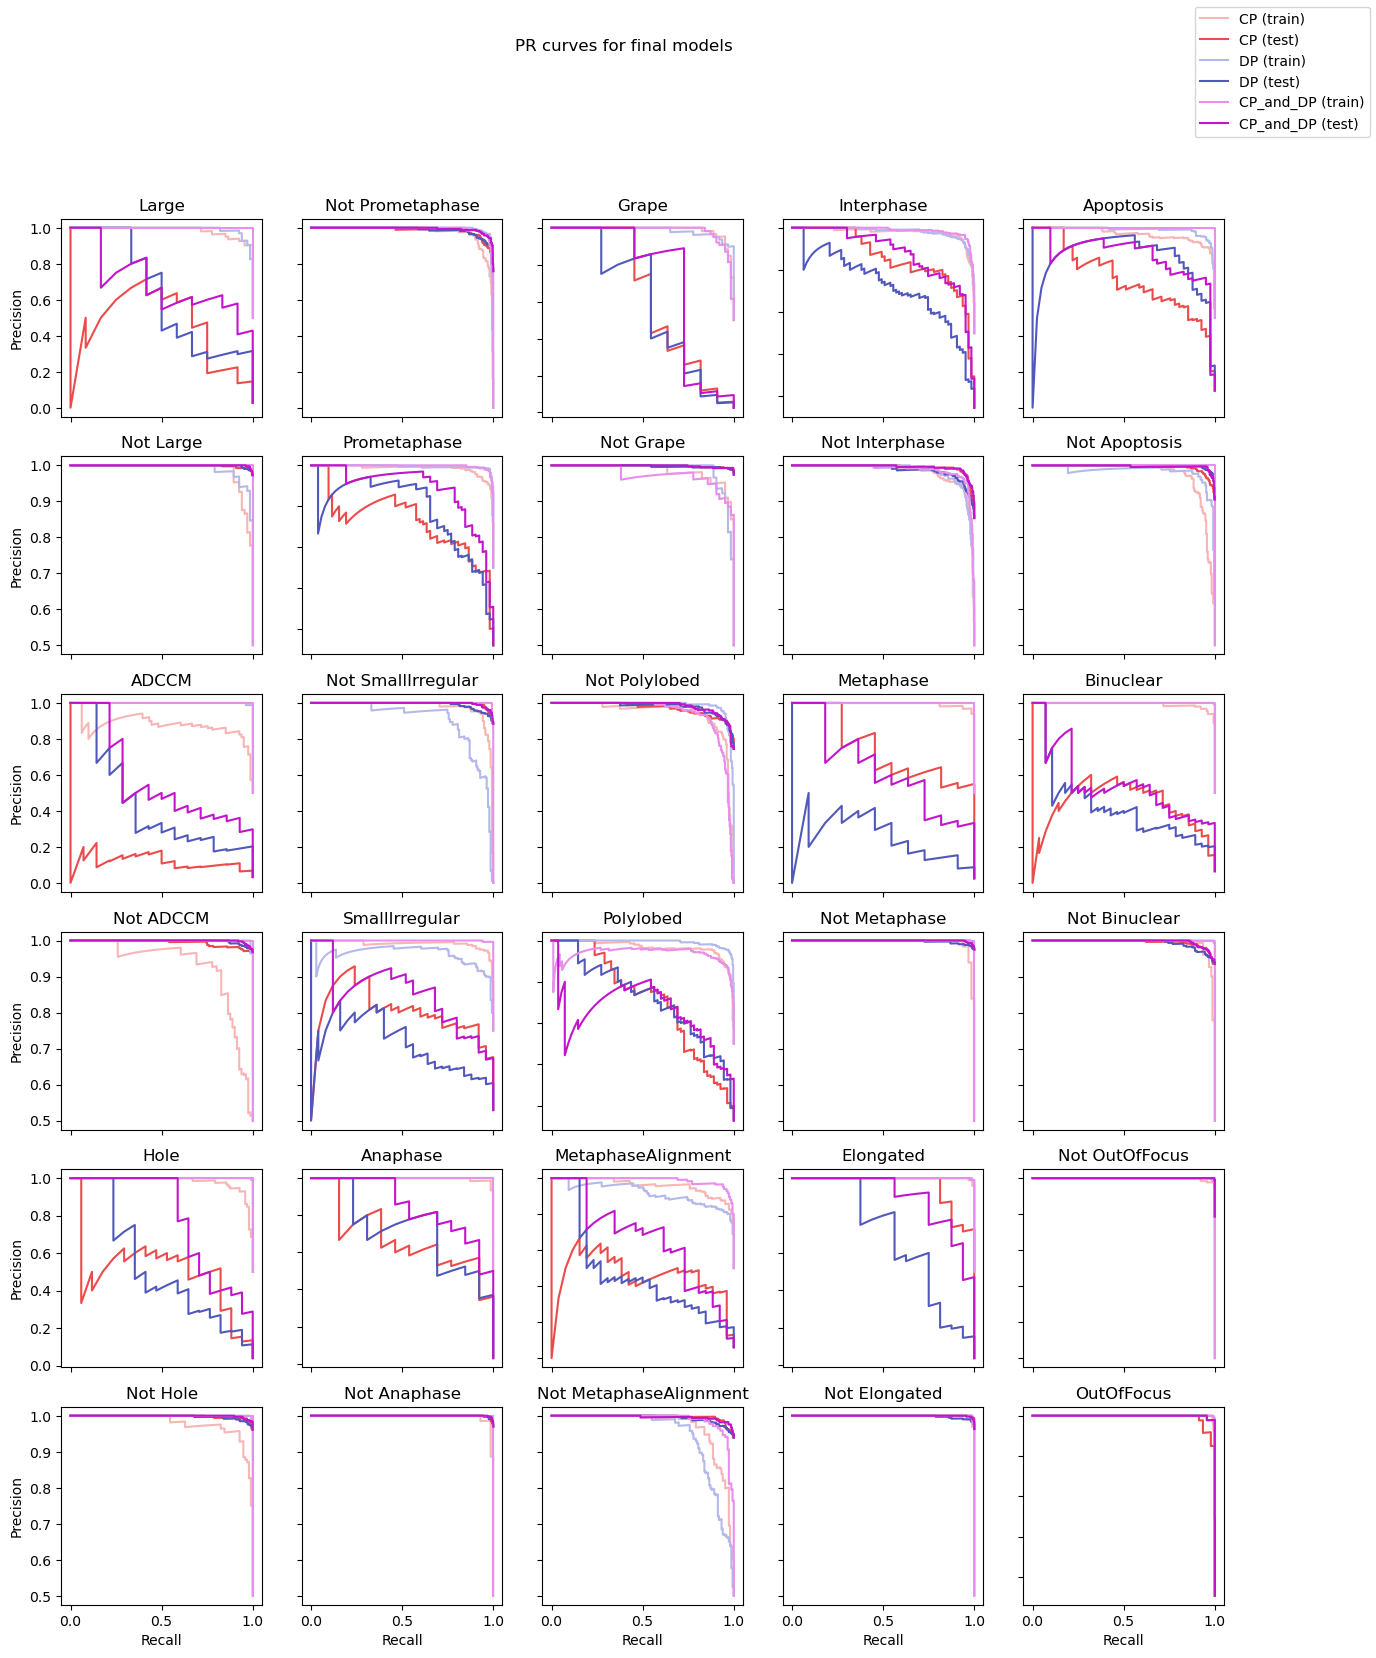

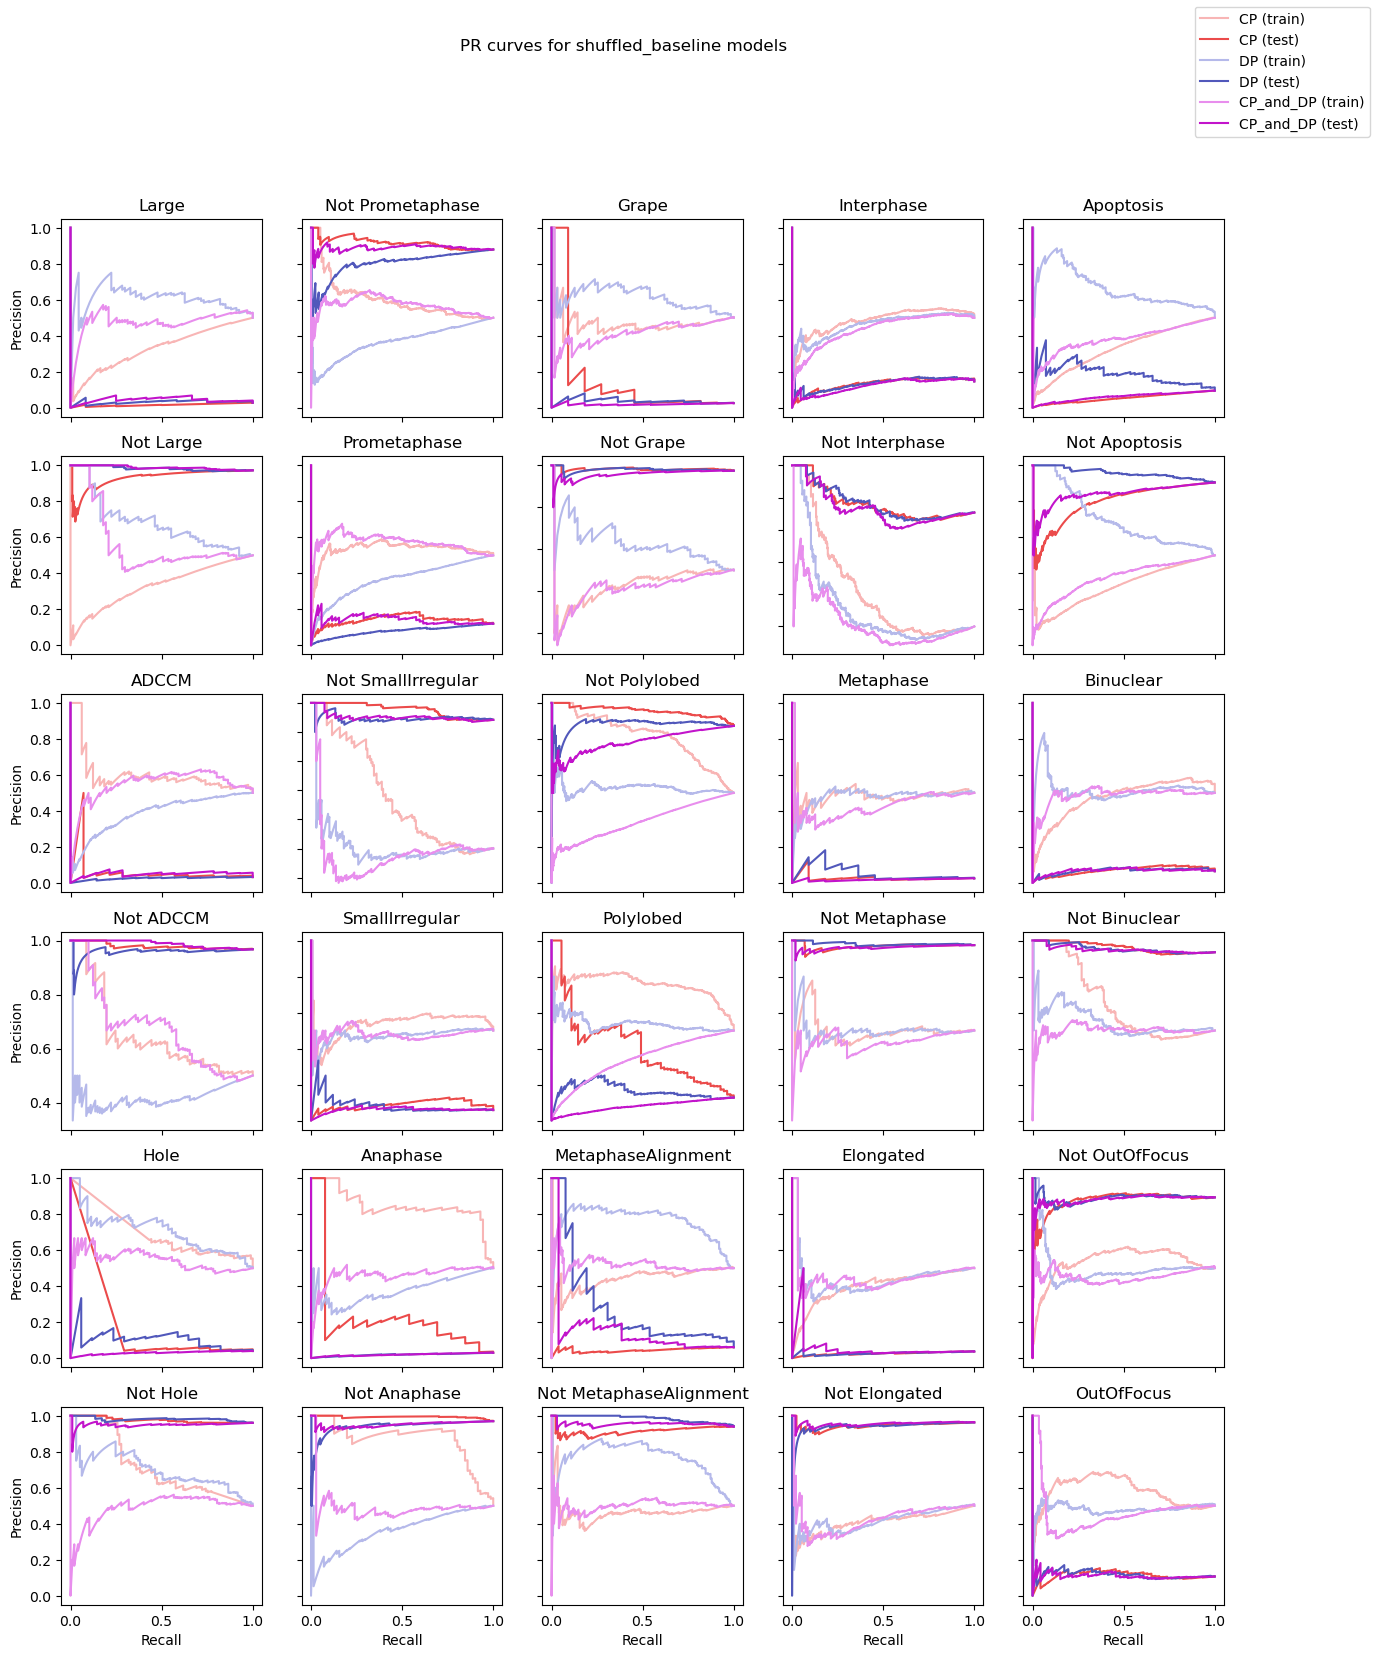

In [154]:
import warnings

warnings.filterwarnings("ignore")

# directory to load the models from
models_dir = pathlib.Path("../2.train_model/models/single_class_models")

# use a list to keep track of scores in tidy long format for each model and dataset combination
compiled_class_PR_curves = []

# define combinations to test over
model_types = ["final", "shuffled_baseline"]
feature_types = ["CP", "DP", "CP_and_DP"]
evaluation_types = ["train", "test"]
phenotypic_classes = features_dataframe["Mitocheck_Phenotypic_Class"].unique()

data_split_colors = {
    "CP_and_DP (test)": "#C214CB",
    "CP_and_DP (train)": "#E88EED",
    "CP (test)": "#EB4B4B",
    "CP (train)": "#F8B5B5",
    "DP (test)": "#5158bb",
    "DP (train)": "#B5B9EA",
}

# data from PR curves will be stored in tidy data format (eventually pandas dataframe)
PR_data = []

for model_type in model_types:

    fig, axs = plt.subplots(6, 5)
    fig.set_size_inches(15, 18)
    ax_x = 0
    ax_y = 0

    for feature_type, evaluation_type, phenotypic_class in itertools.product(
        feature_types, evaluation_types, phenotypic_classes
    ):

        # load single class model for this combination of model type, feature type, and phenotypic class
        single_class_model_path = pathlib.Path(
            f"{models_dir}/{phenotypic_class}_models/{model_type}__{feature_type}.joblib"
        )
        single_class_model = load(single_class_model_path)

        # load single cell data that will be used for evaluation
        single_cell_data = get_dataset(
            features_dataframe, data_split_indexes, evaluation_type
        )
        single_cell_data.loc[
            single_cell_data["Mitocheck_Phenotypic_Class"] != phenotypic_class,
            "Mitocheck_Phenotypic_Class",
        ] = f"Not {phenotypic_class}"
        # because we downsampled negative labels (to offset large label imbalance) in 2.train_model,
        # it is necessary to get the subset of training data that was used to actually train this specific model
        if evaluation_type == "train":
            # first, get indexes of all positive labels (labels that are the desired phenotypic class)
            positive_label_indexes = (
                single_cell_data.loc[
                    single_cell_data["Mitocheck_Phenotypic_Class"] == phenotypic_class
                ]
            ).index
            # next, get the same number of negative labels (labels that are not the desired phenotypic class)
            negative_label_indexes = (
                (
                    single_cell_data.loc[
                        single_cell_data["Mitocheck_Phenotypic_Class"]
                        != phenotypic_class
                    ]
                )
                .sample(positive_label_indexes.shape[0], random_state=0)
                .index
            )
            # the new class training data are the two subsets found above
            # this new class training data will have equal numbers of positive and negative labels
            # this removes the drastic class imbalances
            single_cell_data = single_cell_data.loc[
                positive_label_indexes.union(negative_label_indexes)
            ]

        model_classes = single_class_model.classes_
        X, y = get_X_y_data(single_cell_data, feature_type)

        # predict class probabilities for feature data
        y_probas = single_class_model.predict_proba(X)

        # figure out where to plot PR curves
        # ax_x is x axis coordinate for positive label PR curve, ax_y is y axis coordinate for positive label PR curve
        # negative label PR curves go below positive label (so ax_x+1)
        # index of phenotypic_class gives us an idea of where it should be plotted
        phenotypic_class_index = phenotypic_classes.tolist().index(phenotypic_class)
        ax_x = (
            int(phenotypic_class_index / 5) * 2
        )  # multiply by 2 because every positive label has a negative label below it
        ax_y = phenotypic_class_index % 5  # modulus gives us y coordinate

        color_key = f"{feature_type} ({evaluation_type})"
        plot_color = data_split_colors[color_key]

        for index, model_class in enumerate(model_classes):
            # get precision, recall, threshold values for the model class (positive or negative label)
            precision, recall, thresholds = precision_recall_curve(
                y, y_probas[:, index], pos_label=model_class
            )
            axs[ax_x + index, ax_y].plot(
                recall, precision, label=color_key, color=plot_color
            )
            # set title and axis labels for subplot
            axs[ax_x + index, ax_y].set_title(model_class)
            axs[ax_x + index, ax_y].set(xlabel="Recall", ylabel="Precision")

            # add pr data to compiled dataframe
            # PR_data.append(
            #     pd.DataFrame(
            #         {
            #             "Model_Class": model_class,
            #             "PR_Threshold": thresholds,
            #             "Precision": precision,
            #             "Recall": recall,
            #             "Data_Split": evaluation_type,
            #             "Shuffled": "shuffled" in model_type,
            #             "Feature_Type": feature_type
            #         }
            #     )
            # )

    # only label outer plots
    for ax in axs.flat:
        ax.label_outer()

    # add title to figure with all subplots
    fig.suptitle(f"PR curves for {model_type} models")
    # add legend to figure with all subplots
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.show()
    
    

# compile PR data
# PR_data = pd.concat(PR_data, axis=0).reset_index(drop=True)